<a href="https://colab.research.google.com/github/olszewskip/Sign_Language/blob/master/sign_language_DL_with_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass classification of images with convolutional networks
The data comes from this repository:
https://github.com/ardamavi/Sign-Language-Digits-Dataset

The images are of various indyviduals' right hands presenting a single digit in a sign language. A sample is displayed below.

### Notable:
* Compare various  approaches and hyperparameters using cross-validation in a basic grid-search.
* This includes using/not-using data augmentation,
* and tuning of the batch size and learning rate.
* We also compare the performance of a simple (sequential, not very deep) model against MobileNet V2.

### More details:
* The test data in each fold is never augmented. The folds are obtained by shuffling followed by a stratified split into 5 chunks.
* Definition of the model includes: its architecture, size of the images, data_augmentation procedure (or lack thereof), batch_size, optimizer and its learning_rate, loss function, fraction of the train-data that is put aside for early-stopping, patience (in epochs) of the early-stopping, maximal number of epochs.
* Only some of the above are examined below. But the procedure is straightforward enough to enable tuning any of those options. 

### Summary of the results:
* ...
* ...


---
Google-Colab specific biolerplate and imports

In [2]:
from tensorflow import test
test.gpu_device_name()

'/device:GPU:0'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.logging import set_verbosity, ERROR
set_verbosity(ERROR)

Using TensorFlow backend.


---
Define path to the directory where the images are.

The latter are actually grouped into subdirectories specific for each label,
ie. "0", "1", ..., "9" in this case.

In [6]:
working_dir = os.path.join("/content/gdrive/My Drive/Colab Notebooks/Sign_Language/")
github_data_dir = os.path.join(working_dir, "data/ardamavi/Dataset")

os.listdir(github_data_dir)

['0', '5', '3', '6', '2', '9', '4', '7', '8', '1']

---
Examine how many images are in each subdirectory.

Remember the total count.

In [7]:
def examine_file_counts(path):
  
  total_count = 0
  
  for class_ in os.listdir(path):
    from_dir = os.path.join(path, class_)
    whole_count = len(os.listdir(from_dir))
    total_count += whole_count
    print(f"class {class_}: {whole_count} photos")

  print(f"{total_count} photos in total")
  return total_count

total_count = examine_file_counts(github_data_dir)

class 0: 205 photos
class 5: 207 photos
class 3: 206 photos
class 6: 207 photos
class 2: 206 photos
class 9: 204 photos
class 4: 207 photos
class 7: 206 photos
class 8: 208 photos
class 1: 206 photos
2062 photos in total


---
This is not a huge dataset.
We can load all the images into memory.

Still, it is convenient to use the generator provided
by keras to:
* automatically pair images with labels,
* one-hot-encode the labels,
* and to shufle.

It can also serve to resize the images away from the
original resolution, which is 100 x 100.

In [0]:
def get_data_from_dir(img_dim,
                      dir_=github_data_dir,
                      total_count=total_count,
                      seed=123):
  data_gen =\
    ImageDataGenerator(rescale=1/255).flow_from_directory(
      dir_,
      target_size = (img_dim, img_dim),
      batch_size = total_count,
      shuffle=True,
      class_mode='categorical',#'sparse',
      seed=seed)
  return next(data_gen)

---
Plot ten random images to get a feel for how the look.

In [0]:
X, y = get_data_from_dir(img_dim=100)

Found 2062 images belonging to 10 classes.


In [0]:
np.unique(y, return_counts=True, axis=0)

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([204, 208, 206, 207, 207, 207, 206, 206, 206, 205]))

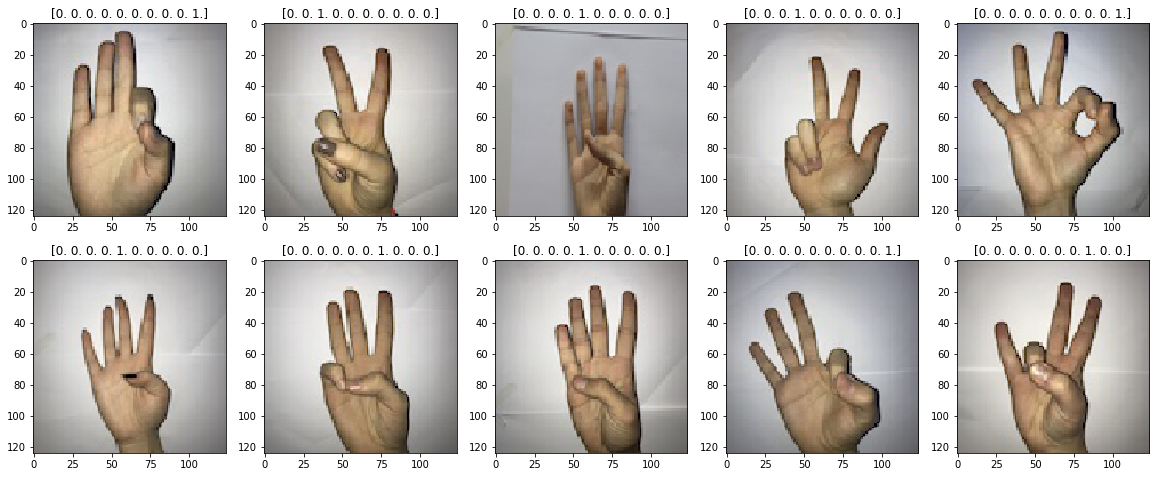

In [19]:
samples = []
for _ in range(10):
  idx = np.random.choice(total_count)
  samples.append((X[idx], y[idx]))
  
fig, axes = plt.subplots(2, 5, figsize=(20,8))
for (img, label), ax in zip(samples, axes.ravel()):
  ax.title.set_text(str(label))
  ax.imshow(img)

---
Define a function, that  returns a function that returns an uncompiled model. The compilcatoin is due to the need to parametrized those model producing functions with image dimensions.

In [0]:
def get_simple_seq(img_dim):
  
  def simple_seq():
    activ = 'elu'
    inputs = Input(shape = (img_dim, img_dim, 3))
    x = Conv2D(32, (3,3), strides=(1,1), padding='same', activation=activ)(inputs)
    x = MaxPooling2D((3,3))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), strides=(1,1), padding='same', activation=activ)(x)
    x = MaxPooling2D((3,3))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', activation=activ)(x)
    x = MaxPooling2D((3,3))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model
  
  return simple_seq

---
Use startified k-fold cross-validation (say with k=5).

Use a single function to perform:
* splitting of the data into folds
* fitting to (k-1)/k fraction of the data and testing on the other 1/k
* return average accuracy and some measure of its variance

The function accepts some hyperparameters as its arguments.

In [0]:
def get_accuracy_in_cv(model_producing_function,
                       X, y,                
                       batch_size,
                       learning_rate,
                       augmentation_kwargs,
                       VAL_SPLIT = 0.1,
                       PATIENCE = 4,
                       N_SPLITS = 5):
  
  cv_results = []

  skf5 = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)
  folds = skf5.get_n_splits()

  for fold_index, (train_index, test_index) in enumerate(skf5.split(X, y)):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    augment_data_gen = ImageDataGenerator(\
                          validation_split=VAL_SPLIT)#,
                          #**augmentation_kwargs
                          #                )

    train_data_gen = augment_data_gen.flow(X_train, y_train,
                                           batch_size=batch_size,
                                           subset='training',
                                           )

    val_data_gen = augment_data_gen.flow(X_train, y_train,
                                         batch_size=batch_size,
                                         subset='validation',
                                         )


    model = model_producing_function()
    model.compile(loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer=Adam(lr=learning_rate))

    callbacks = [EarlyStopping(monitor='val_acc',
                               patience=PATIENCE,
                               verbose=0,
                               restore_best_weights=True)]

    model.fit_generator(train_data_gen,
                        steps_per_epoch = int(np.ceil((1-VAL_SPLIT) * len(X_train) / batch_size)),
                        validation_data = val_data_gen,
                        validation_steps = int(np.ceil(VAL_SPLIT * len(X_train) / batch_size)),
                        epochs=50,
                        callbacks=callbacks,
                        verbose=0
                       )
    
    fold_loss, fold_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {fold_index + 1}/{folds}: {fold_acc:.4f} acc.")
    cv_results.append(fold_acc)
  
  cv_mean, cv_delta = np.mean(cv_results), 2*np.std(cv_results)
  print(f"Average accuracy: {cv_mean:.4f} +- {cv_delta:.4f}")
  
  return cv_mean, cv_delta

---
Define a grid of hyperparameters. Each combination will be passed to the cross-validating function.

In [0]:
batch_sizes = [32, 256]

learning_rates = [0.0001, 0.0004, 0.001]

augmentation_kwargs_options = [\
  ("no", dict(rotation_range=0,
                height_shift_range=0.0,
                width_shift_range=0.0,
                zoom_range=0.0)),
  ("yes", dict(rotation_range=20,
                height_shift_range=0.1,
                width_shift_range=0.1,
                zoom_range=0.1))
                              ]

---
Perform the grid search with cross-validation for our simple sequential model.

In [0]:
print("Simple sequential model")
IMG_DIM = 100

X, y = get_data_from_dir(img_dim=IMG_DIM)

simple_seq_grid_cv = []

for batch_size in batch_sizes:
  for learning_rate in learning_rates:
    for augmentation_description, augmentation_kwargs in augmentation_kwargs_options:
      
      print(f"Batch size = {batch_size}, lr = {learning_rate}, augmentation: {augmentation_description}")
      
      cv_mean, cv_delta =\
      get_accuracy_in_cv(get_simple_seq(img_dim=IMG_DIM),
                         X, y,
                         batch_size=batch_size,
                         learning_rate=learning_rate,
                         augmentation_kwargs=augmentation_kwargs)
      
      cv_result = dict(batch_size=batch_size,
                       learning_rate=learning_rate,
                       augmentation=augmentation_description,
                       mean_accuracy=cv_mean,
                       acc_std_x2=cv_delta)
      
      simple_seq_grid_cv.append(cv_result)
    

Simple sequential model
Found 2062 images belonging to 10 classes.
Batch size = 32, lr = 0.0005, augmentation: no
Fold 1/5: 0.9617 acc.
Fold 2/5: 0.9517 acc.
Fold 3/5: 0.9440 acc.
Fold 4/5: 0.9439 acc.
Fold 5/5: 0.9633 acc.
Average accuracy: 0.9529 +- 0.0167
Batch size = 32, lr = 0.0005, augmentation: yes
Fold 1/5: 0.9880 acc.
Fold 2/5: 0.9493 acc.
Fold 3/5: 0.9805 acc.
Fold 4/5: 0.9732 acc.
Fold 5/5: 0.9609 acc.
Average accuracy: 0.9704 +- 0.0277
Batch size = 32, lr = 0.001, augmentation: no
Fold 1/5: 0.9569 acc.
Fold 2/5: 0.9565 acc.
Fold 3/5: 0.9367 acc.
Fold 4/5: 0.9732 acc.
Fold 5/5: 0.9511 acc.
Average accuracy: 0.9549 +- 0.0234
Batch size = 32, lr = 0.001, augmentation: yes
Fold 1/5: 0.9545 acc.
Fold 2/5: 0.9034 acc.
Fold 3/5: 0.8808 acc.
Fold 4/5: 0.9805 acc.
Fold 5/5: 0.9829 acc.
Average accuracy: 0.9404 +- 0.0826
Batch size = 32, lr = 0.002, augmentation: no
Fold 1/5: 0.9426 acc.
Fold 2/5: 0.9251 acc.
Fold 3/5: 0.9100 acc.
Fold 4/5: 0.9220 acc.
Fold 5/5: 0.9487 acc.
Average a

In [0]:
print("Simple sequential model")
ordered_columns = ['batch_size', 'learning_rate', 'augmentation', 'mean_accuracy', 'acc_std_x2']
pd.DataFrame(simple_seq_grid_cv)[ordered_columns].sort_values(by='mean_accuracy', ascending=False)

Simple sequential model


,batch_size,learning_rate,augmentation,mean_accuracy,acc_std_x2
1,32,0.0005,yes,0.970380,0.027689
5,32,0.0020,yes,0.962714,0.019509
8,128,0.0010,no,0.961267,0.024154
10,128,0.0020,no,0.960777,0.016251
7,128,0.0005,yes,0.960587,0.045126
6,128,0.0005,no,0.959280,0.025140
2,32,0.0010,no,0.954894,0.023407
0,32,0.0005,no,0.952936,0.016672
11,128,0.0020,yes,0.948140,0.045897
9,128,0.0010,yes,0.944814,0.069547


---
Repeat the same grid-search as above but with a more sophisticated convolutional network. One that can be imported from keras. Let's choose MobileNetV2.

In [0]:
def get_mobilenet(img_dim):
  
  def mobilenet():
    MobileNetV2_ = MobileNetV2(include_top=False,
                               weights=None,
                               input_shape=(img_dim, img_dim, 3))
      
    x = MobileNetV2_.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(256, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)
    model = Model(inputs=MobileNetV2_.input, outputs=output)
    return model
  
  return mobilenet

In [0]:
mobilenet_model = get_mobilenet(124)()

In [0]:
mobilenet_model.compile(loss='categorical_crossentropy',
                metrics=['categorical_accuracy'],
                optimizer=Adam(lr=0.001))

In [0]:
from sklearn.utils import shuffle

In [11]:
X, y = get_data_from_dir(124)

Found 2062 images belonging to 10 classes.


In [12]:
X.shape


(2062, 124, 124, 3)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y)

In [29]:
MobileNetV2_ = MobileNetV2(include_top=True,
                           classes=10,
                           weights=None,
                           input_shape=(124, 124, 3))

# x = MobileNetV2_.output
# x = GlobalMaxPooling2D()(x)
# x = Dense(256, activation='relu')(x)
# x = Dense(256, activation='relu')(x)
# output = Dense(10, activation='softmax')(x)
mobilenet_model = Model(inputs=MobileNetV2_.input, outputs=MobileNetV2_.output)

mobilenet_model.compile(loss='categorical_crossentropy',
                        metrics=['accuracy'],
                        optimizer='adam')

mobilenet_model.fit(X_train, y_train,
                    batch_size = 256,
                    validation_data = (X_train, y_train),
                    epochs=10,
                    verbose=1
                   )

Train on 1855 samples, validate on 1855 samples
Epoch 1/10
1855/1855 [==============================] - 27s 15ms/step - loss: 2.2536 - acc: 0.1736 - val_loss: 7.9951 - val_acc: 0.1720
Epoch 2/10
1855/1855 [==============================] - 5s 3ms/step - loss: 1.7055 - acc: 0.3978 - val_loss: 11.6246 - val_acc: 0.1040
Epoch 3/10
1855/1855 [==============================] - 5s 3ms/step - loss: 1.2440 - acc: 0.5396 - val_loss: 10.9425 - val_acc: 0.1078
Epoch 4/10
1855/1855 [==============================] - 5s 3ms/step - loss: 0.7459 - acc: 0.7434 - val_loss: 13.1386 - val_acc: 0.1148
Epoch 5/10
1855/1855 [==============================] - 5s 3ms/step - loss: 0.3977 - acc: 0.8577 - val_loss: 11.8988 - val_acc: 0.1747
Epoch 6/10
1855/1855 [==============================] - 5s 3ms/step - loss: 0.1864 - acc: 0.9337 - val_loss: 11.3524 - val_acc: 0.1827
Epoch 7/10
1855/1855 [==============================] - 5s 3ms/step - loss: 0.1077 - acc: 0.9660 - val_loss: 12.3216 - val_acc: 0.1445
Epoch 

In [0]:
mobilenet_model.evaluate(X, y)

2062/2062 [==============================] - 4s 2ms/step


[5.691848080789546, 0.2812803103782735]

In [0]:
    model.compile(loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer=Adam(lr=learning_rate))

    callbacks = [EarlyStopping(monitor='val_loss',
                               patience=PATIENCE,
                               verbose=0,
                               restore_best_weights=True)]

    model.fit_generator(train_data_gen,
                        steps_per_epoch = int(np.ceil((1-VAL_SPLIT) * len(X_train) / batch_size)),
                        validation_data = val_data_gen,
                        validation_steps = int(np.ceil(VAL_SPLIT * len(X_train) / batch_size)),
                        epochs=50,
                        callbacks=callbacks,
                        verbose=0
                       )

In [0]:
print("MobileNet V2")
IMG_DIM = 124

X, y = get_data_from_dir(img_dim=IMG_DIM)

mobilenet_grid_cv = []

for batch_size in batch_sizes:
  for learning_rate in learning_rates:
    for augmentation_description, augmentation_kwargs in augmentation_kwargs_options:
      
      print(f"Batch size = {batch_size}, lr = {learning_rate}, augmentation: {augmentation_description}")
      
      cv_mean, cv_delta =\
      get_accuracy_in_cv(get_mobilenet(img_dim=IMG_DIM),
                         X, y,
                         batch_size=batch_size,
                         learning_rate=learning_rate,
                         augmentation_kwargs=augmentation_kwargs)
      
      cv_result = dict(batch_size=batch_size,
                       learning_rate=learning_rate,
                       augmentation=augmentation_description,
                       mean_accuracy=cv_mean,
                       acc_std_x2=cv_delta)
      
      mobilenet_grid_cv.append(cv_result)
    

MobileNet V2
Found 2062 images belonging to 10 classes.
Batch size = 32, lr = 0.0001, augmentation: no
Fold 1/5: 0.3612 acc.
Fold 2/5: 0.1111 acc.


KeyboardInterrupt: ignored

In [0]:
print("Mobilenet V2")
ordered_columns = ['batch_size', 'learning_rate', 'augmentation', 'mean_accuracy', 'acc_std_x2']
pd.DataFrame(mobilenet_grid_cv)[ordered_columns].sort_values(by='mean_accuracy', ascending=False)

---
### End